Author: Sajjad Azami

January 2nd, 2021

In [215]:
import pandas as pd
import numpy as np

In [27]:
df = pd.read_csv('./us_census_data.csv')

# Preprocessing

First, we want to start by checking for missing values.
After a quick look at the data, turns out missing values are marked by '?'. So we will replace them with NaN to be able to use the standard pandas methods.

In [28]:
df.isna().any()

age               False
workclass         False
fnlwgt            False
education         False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
hours-per-week    False
native-country    False
capital           False
income            False
dtype: bool

In [29]:
df = df.replace('?', np.NaN)
df.isna().any()

age               False
workclass          True
fnlwgt            False
education         False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
hours-per-week    False
native-country     True
capital           False
income            False
dtype: bool

In [30]:
print(df['workclass'].isna().value_counts())
print(df['occupation'].isna().value_counts())
print(df['native-country'].isna().value_counts())

False    46012
True      2830
Name: workclass, dtype: int64
False    46033
True      2809
Name: occupation, dtype: int64
False    47985
True       857
Name: native-country, dtype: int64



Filling missing values with the most common values of that feature. Although there are more complex methods of dealing with this issue, we will try to focus on the encoding methods in what follows

In [31]:
df['workclass'] = df['workclass'].fillna(df['workclass'].value_counts().index[0])
df['occupation'] = df['occupation'].fillna(df['occupation'].value_counts().index[0])
df['native-country'] = df['native-country'].fillna(df['native-country'].value_counts().index[0])

In [32]:
df.isna().any()

age               False
workclass         False
fnlwgt            False
education         False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
hours-per-week    False
native-country    False
capital           False
income            False
dtype: bool

In [33]:
df.dtypes
# so we will leave ['age', 'fnlwgt', 'hours-per-week', 'capital'] since they are already numerical


age                int64
workclass         object
fnlwgt             int64
education         object
marital-status    object
occupation        object
relationship      object
race              object
sex               object
hours-per-week     int64
native-country    object
capital            int64
income            object
dtype: object

In [34]:
df['income_binary'] = (df['income'] == '<=50K').astype(int)
# target variable is binary, so we'll replace it with 0,1 values


In [35]:
categorical_columns = ['workclass', 'education', 'marital-status',
                  'occupation', 'relationship','race',
                  'sex','native-country' ]

df[categorical_columns].nunique()

workclass          6
education         16
marital-status     7
occupation        14
relationship       6
race               5
sex                2
native-country    41
dtype: int64

# Model Comparison
We want to compare two models: 
* GradientBoostingClassifier
* CatBoost

We also want to try three different encoding methods:
* One-Hot Encoding
* Label Encoding
* Target Encoding

First, we fix the encoding method to One-Hot as this is the most natural way of dealing with categorical data. The biggest downside of this method is sparsification of the data, but our goal is to compare the models first. We later will try other encoding methods. 

In [36]:
# one-hot encoding for categorical columns
categorical_df = df[categorical_columns]
one_hot_df = pd.get_dummies(categorical_df, columns = categorical_columns)
df_one_hot_drop = df.drop(categorical_columns, axis = 1)
df = pd.concat([df_one_hot_drop, one_hot_df], axis = 1)
df

,age,fnlwgt,hours-per-week,capital,income,income_binary,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,40,2174,<=50K,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,<=50K,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,40,0,<=50K,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,40,0,<=50K,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,40,0,<=50K,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,215419,36,0,<=50K,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
48838,64,321403,40,0,<=50K,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
48839,38,374983,50,0,<=50K,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
48840,44,83891,40,5455,<=50K,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## Train, Validation and Test Set
We use %50 of the data for training, %25 percent for validation and %25 percent for test. 

In [51]:
from sklearn.model_selection import train_test_split
X = df.drop(['income', 'income_binary'], axis=1)
y = df['income_binary']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42)
print("Train size: ", X_train.shape)
print("Validation size: ", X_val.shape)
print("Test size: ", X_test.shape)

Train size:  (24542, 101)
Validation size:  (12089, 101)
Test size:  (12211, 101)


## GradientBoosting
n_estimators=50, learning_rate=1.0

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
import time
start = time.time()
xgb_clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
    max_depth=3, random_state=0).fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
print(xgb_clf.score(X_val, y_val))

Training time: 2.393467903137207s
0.8698817106460418


# CatBoost
iterations=100, learning_rate=0.1, loss_function='CrossEntropy'

In [55]:
from catboost import CatBoostClassifier
start = time.time()
cat_clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    loss_function='CrossEntropy', verbose=False).fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
cat_clf.score(X_val, y_val)

Training time: 0.9012150764465332s


0.8688890727107288

### So here is the initial comparison:
| Model | Training Time | Validation Accuracy |
| --- | --- | --- |
| GradientBoosting | 2.393 | 86.98 |
| CatBoost | 0.901 | 86.88 |

This shows that with the current parameters, CatBoost is far better in terms of training time, but almost the same accuracy. So to make a comparison with equal resources (training time here), we increase the number of iterations for CatBoost to match the training time of ~2.3 seconds.

In [56]:
start = time.time()
cat_clf = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    loss_function='CrossEntropy', verbose=False).fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
cat_clf.score(X_val, y_val)

Training time: 2.806924819946289s


0.876664736537348

### Parameter Gridsearch for GradientBoosting
Here we perform a quick search to improve the accuracy of the GradientBoosting as well

In [57]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[10,100], 'max_depth':[3, 10, 20]}
xgb_clf = GradientBoostingClassifier()
clf = GridSearchCV(xgb_clf, parameters)
clf.fit(X_train, y_train.values)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
      

In [60]:
print(clf.best_params_)
print(clf.score(X_val, y_val))

{'max_depth': 10, 'n_estimators': 100}
0.8688890727107288


In [61]:
print(clf.score(X_test, y_test))
print(cat_clf.score(X_test, y_test))

0.8663500122840062
0.8711817213987388


### Final comparison (with One-hot encoding):
| Model | Training Time | Validation Accuracy | Test Accuracy |
| --- | --- | --- | --- |
| GradientBoosting | 2.281 | 86.88 | 86.63 |
| CatBoost | 2.806 | 87.66 | 87.11 |


# Other Encodings
Now we'll try using other encoding methods and see the possible impact on the performance. Since this part is focused on encoding methods, we will fix the model parameters to best parameters of previous part.
* CatBoost {'iterations' : 300, 'learning_rate' : 0.1, 'loss_function' : 'CrossEntropy'}
* GradientBoosting: {'max_depth': 3, 'n_estimators': 100}

We need to reload the dataset again and redo the necessary preprocessings.

## Label Encoder
We start with Label Encoder.

In [63]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('./us_census_data.csv')
df = df.replace('?', np.NaN)
df['workclass'] = df['workclass'].fillna(df['workclass'].value_counts().index[0])
df['occupation'] = df['occupation'].fillna(df['occupation'].value_counts().index[0])
df['native-country'] = df['native-country'].fillna(df['native-country'].value_counts().index[0])
df['income_binary'] = (df['income'] == '<=50K').astype(int)
X = df.drop(['income', 'income_binary'], axis=1)
y = df['income_binary']

# Here we encode categorical columns
X[categorical_columns] = X[categorical_columns].apply(LabelEncoder().fit_transform)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42)


In [64]:
X_train

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital
21486,28,2,129882,15,4,0,4,2,0,40,38,0
41634,17,2,141445,0,4,7,3,4,1,30,38,0
26548,43,2,326379,11,0,2,1,4,1,40,38,0
15346,25,2,199472,8,4,0,1,4,0,38,38,0
38310,47,4,114222,7,2,3,0,4,1,25,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...
27929,28,2,148429,11,2,6,0,4,1,40,38,0
6770,30,2,378723,15,0,0,3,4,0,55,38,0
937,41,2,132222,14,2,9,0,4,1,40,38,-2415
44886,39,2,312271,15,2,11,0,4,1,60,38,0


In [65]:
start = time.time()
cat_clf = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    loss_function='CrossEntropy', verbose=False).fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
print(cat_clf.score(X_val, y_val))
print(cat_clf.score(X_test, y_test))

Training time: 2.547102928161621s
0.8752584994623211
0.8710179346490868


In [66]:
start = time.time()
xgb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=3, random_state=0).fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
print(xgb_clf.score(X_val, y_val))
print(xgb_clf.score(X_test, y_test))

Training time: 2.1548879146575928s
0.8687236330548432
0.8611088362951437


### Comparison (with label encoding):
| Model | Training Time | Validation Accuracy | Test Accuracy |
| --- | --- | --- | --- |
| GradientBoosting | 2.154 | 86.87 | 86.11 |
| CatBoost | 2.547 | 87.52 | 87.10 |


### Note:
For label encoding and target encoding, unlike one-hot method, we don't have many new features generated. So it makes sense to check feature importances as well to get insight about the data. 

In [67]:
xgb_clf.feature_importances_

array([0.05020323, 0.00909001, 0.04043135, 0.09410626, 0.00777151,
       0.02218894, 0.40350881, 0.00238707, 0.00227762, 0.05240448,
       0.00688437, 0.30874634])

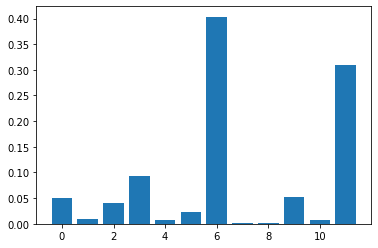

In [68]:
from matplotlib import pyplot

pyplot.bar(range(len(xgb_clf.feature_importances_)), xgb_clf.feature_importances_)
pyplot.show()

## Target Encoder
Now we try target encoder. In this method, we replace the categorical value with the average value of the target variable.

In [207]:
df = pd.read_csv('./us_census_data.csv')
df = df.replace('?', np.NaN)
df['workclass'] = df['workclass'].fillna(df['workclass'].value_counts().index[0])
df['occupation'] = df['occupation'].fillna(df['occupation'].value_counts().index[0])
df['native-country'] = df['native-country'].fillna(df['native-country'].value_counts().index[0])
df['income_binary'] = (df['income'] == '<=50K').astype(int)

X = df.drop(['income', 'income_binary'], axis=1)
y = df['income_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

merged_train = X_train.merge(y_train, left_index=True, right_index=True, how='inner')
for column in categorical_columns:
    encodings = merged_train.groupby(column)['income_binary'].mean().reset_index()
    X_train = X_train.merge(encodings, how='left', on=column)
    X_train[column] = X_train['income_binary']
    X_train = X_train.drop(['income_binary'], axis=1)
    X_val = X_val.merge(encodings, how='left', on=column)
    X_val[column] = X_val['income_binary']
    X_val = X_val.drop(['income_binary'], axis=1)
    X_test = X_test.merge(encodings, how='left', on=column)
    X_test[column] = X_test['income_binary']
    X_test = X_test.drop(['income_binary'], axis=1)
X_test['native-country'] = X_test['native-country'].fillna(X_test['native-country'].value_counts().index[0])

In [214]:
start = time.time()
xgb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=3, random_state=0).fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
print(xgb_clf.score(X_val, y_val))
print(xgb_clf.score(X_test, y_test))

Training time: 2.165092945098877s
0.8666556373562743
0.86037179592171


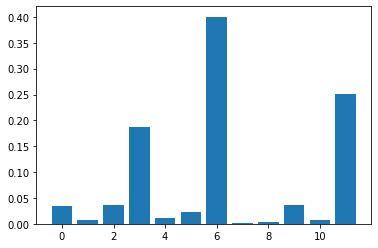

In [210]:
pyplot.bar(range(len(xgb_clf.feature_importances_)), xgb_clf.feature_importances_)
pyplot.show()

In [211]:
X_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'hours-per-week',
       'native-country', 'capital'],
      dtype='object')

In [212]:
start = time.time()
cat_clf = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    loss_function='CrossEntropy', verbose=False).fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
print(cat_clf.score(X_val, y_val))
print(cat_clf.score(X_test, y_test))

Training time: 2.5396552085876465s
0.8757548184299777
0.8717549750225206


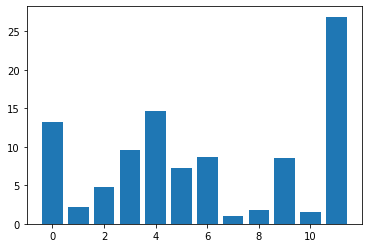

In [213]:
pyplot.bar(range(len(cat_clf.feature_importances_)), cat_clf.feature_importances_)
pyplot.show()

### Comparison (with target encoding):
| Model | Training Time | Validation Accuracy | Test Accuracy |
| --- | --- | --- | --- |
| GradientBoosting | 2.165 | 86.66 | 86.03 |
| CatBoost | 2.539 | 87.57 | 87.17 |


# Conclusion and Questions

## (1)
The table below summarizes the results for different models and encoding methods

| Model | Encoding Method | Training Time | Validation Accuracy | Test Accuracy |
| --- | --- | --- | --- | --- |
| GradientBoosting | One-hot | 2.281 | 86.88 | 86.63 |
| CatBoost | One-hot | 2.806 | (87.66) | 87.11 |
| GradientBoosting | Label Encoding | 2.154 | 86.87 | 86.11 |
| CatBoost | Label Encoding | 2.547 | 87.52 | 87.10 |
| GradientBoosting | Target Encoding | 2.165 | 86.66 | 86.03 |
| CatBoost | Target Encoding | 2.539 | 87.57 | (87.17) |

It is evident from the results above that CatBoost is performing slightly better in all cases. 
## (2)
I tested three different encoding methods. I expected label encoding to perform the worst since this method is too simple and usually sub-optimal, especially for models using distance metrics. It turns out for this dataset, and with these two methods, different encoding methods don't have a significant impact on the performance. In my opinion, this might be due to existing powerful numerical features like "capital" or "age" (refer to plots above). Another evidence that this might be the case is that, for a feature like "native-country" with 41 (and the most) unique values, the feature importance factor is really low. In other words, the feature does not predict the outcome very well, so the encoding method does not alter the performance as much.

For the final model, I would suggest using Target encoding since it performs almost the same as One-hot, but it does not have the sparsification problem, which could be a bigger issue if the data had more unique categories or more categorical features.

## (3)
I want to briefly mention two ideas that may improve the results:

First, I used a very simple method to deal with missing values. Although I think it may not have a significant impact on performance, there are many more imputation methods worth experimenting with.

Second, I would like to use cross-validation to obtain a more reliable guarantee (not necessarily a higher score) as well as being able to tune hyperparameters even more and search in a wider space.
